# Import libraries

In [1]:
import sys
from pathlib import Path
sys.path.insert(0,'..')
import glob
#!pip install openpyxl

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import h5py
import re

from functools import partial
from multiprocessing import Pool

from lhcsmapi.Time import Time
from lhcsmapi.Timer import Timer
from lhcsmapi.metadata.MappingMetadata import MappingMetadata
from scipy import signal
import xarray as xr

from src.utils.utils import log_acquisition
from src.utils.hdf_tools import acquisition_to_hdf5, load_from_hdf_with_regex
from src.visualisation.sec_quench_visualisation import plot_wiggle_analysis
from src.modeling.sec_quench import *
from src.utils.dataset_utils import *
from src.utils.utils import interp

pd.set_option('display.max_rows', 200)
import warnings
warnings.filterwarnings('ignore')
#%matplotlib widget

In [3]:
%load_ext autoreload

In [ ]:
%matplotlib inline

# Define Paths

In [4]:
file_path  = Path('/eos/project/m/ml-for-alarm-system/private/RB_signals')
data_path = file_path / '20220707_data'
simulation_path = file_path / '20220707_simulation'

# Read the (clean) MP3 file

In [5]:
mp3_fpa_df = pd.read_csv("../data/RB_TC_extract_2022_07_07_processed_filled.csv")
len(mp3_fpa_df)

4399

# Select events to analyze

In [6]:
mp3_fpa_df_unique = mp3_fpa_df.drop_duplicates(subset=['timestamp_fgc', 'Circuit Name'])
lower_limit = Time.to_unix_timestamp('2014-01-01 00:00:00+01:00')
mp3_fpa_df_period = mp3_fpa_df_unique[mp3_fpa_df_unique['timestamp_fgc'] >= lower_limit].reset_index(drop=True) 

mp3_fpa_df_period_all = mp3_fpa_df[mp3_fpa_df['timestamp_fgc'] >= lower_limit].reset_index(drop=True) 
print(len(mp3_fpa_df_period), len(mp3_fpa_df_period_all))

828 3996


In [7]:
# Add information, whether download was successfull
df_acquisition = pd.read_excel("../data/20220707_acquisition_summary.xlsx")
mp3_fpa_df_period_merged = mp3_fpa_df_period.merge(df_acquisition , left_on=['Circuit Name', 'timestamp_fgc'], right_on=['Circuit Name', 'timestamp_fgc'], how="left")
df_to_analyze = mp3_fpa_df_period_merged[mp3_fpa_df_period_merged['VoltageNQPS.*U_DIODE']==1]
len(df_to_analyze)

606

# Analyze all events

In [8]:
fpa_identifier = "RB_RB.A34_1618378572280000000"    
circuit_name = fpa_identifier.split("_")[1]
timestamp_fgc = int(fpa_identifier.split("_")[2])

mp3_fpa_df_subset = mp3_fpa_df[(mp3_fpa_df.timestamp_fgc == timestamp_fgc) & 
                               (mp3_fpa_df['Circuit Name'] == circuit_name)]
all_quenched_magnets = mp3_fpa_df_subset.Position.values
quench_times = mp3_fpa_df_subset["Delta_t(iQPS-PIC)"].values /1e3
        
# load data
data_dir = data_path / (fpa_identifier + ".hdf5")
data = load_from_hdf_with_regex(file_path=data_dir, regex_list=['VoltageNQPS.*U_DIODE'])
df_data = u_diode_data_to_df(data, len_data=len(data[0]))

# load simulation 
simulation_dir = simulation_path / (fpa_identifier + ".hdf")
data_sim = load_from_hdf_with_regex(file_path=simulation_dir, regex_list=["0v_magf"])
df_sim = u_diode_simulation_to_df(data_sim, circuit_name=circuit_name)

# save magnet order for later useage
magnet_list=df_sim.columns
                        
# drop quenched magnet
max_time = df_data.index.max()
df_data_noq = drop_quenched_magnets(df_data, all_quenched_magnets, quench_times, max_time)
df_sim_noq = drop_quenched_magnets(df_sim, all_quenched_magnets, quench_times, max_time)

# sometimes only noise is stored, mean must be in windwo -1, -10
df_data_noq = df_data_noq.drop(df_data_noq.columns[~(-1>df_data_noq.mean()) & (-10<df_data_noq.mean())], axis=1)

# align 
t_first_extraction = min(float(mp3_fpa_df_subset['Delta_t(EE_odd-PIC)'].values[0]) / 1000, 
                         float(mp3_fpa_df_subset['Delta_t(EE_even-PIC)'].values[0]) / 1000)
df_data_aligned = align_u_diode_data(df_data_noq.copy(), t_first_extraction)

# cut out time frame to analyze, [-0.25, 1] is 1336 samples
time_frame = [-0.25, 1]
df_data_cut = df_data_aligned[(time_frame[0] <= df_data_aligned.index) & (time_frame[1] >= df_data_aligned.index)]

# adjust simulation length to data 
df_sim_noq_resampled = interp(df_sim_noq, df_data_cut.index)

# add quenched magnets again for continuity
dropped_columns_data = magnet_list[~magnet_list.isin(df_data_cut.columns)]
dropped_columns_simulation = magnet_list[~magnet_list.isin(df_sim_noq_resampled.columns)]
df_data_cut[dropped_columns_data] = np.nan
df_sim_noq_resampled[dropped_columns_simulation] = np.nan
# bring into electrical order again
df_data_cut = df_data_cut[magnet_list]
df_sim_noq_resampled = df_sim_noq_resampled[magnet_list]

# add data and simulation
xr_dataset = data_to_xarray(df_data=df_data_cut, df_simulation=df_sim_noq_resampled, event_identifier=fpa_identifier)
xr_dataset

<xarray.DataArray (event: 1, type: 2, el_position: 154, time: 1336)>
array([[[[ 9.40498350e-01,  9.56132900e-01,  9.91193800e-01, ...,
          -1.10788600e+01, -1.10798080e+01, -1.10793340e+01],
         [ 9.50447100e-01,  9.43815230e-01,  9.67031500e-01, ...,
          -1.10291120e+01, -1.10300590e+01, -1.10300590e+01],
         [ 9.51869960e-01,  9.45709200e-01,  9.61818700e-01, ...,
          -1.11011300e+01, -1.11030240e+01, -1.11025505e+01],
         ...,
         [ 9.56607800e-01,  9.59449770e-01,  9.55659870e-01, ...,
          -1.10703320e+01, -1.10693850e+01, -1.10703320e+01],
         [ 9.54238900e-01,  9.57080840e-01,  9.54711900e-01, ...,
          -1.10826510e+01, -1.10802820e+01, -1.10802820e+01],
         [ 9.52816000e-01,  9.56607800e-01,  9.47130200e-01, ...,
          -1.11205550e+01, -1.11205550e+01, -1.11215020e+01]],

        [[-1.54554971e-04, -1.54278175e-04, -1.54001378e-04, ...,
          -1.14577257e+01, -1.13932583e+01, -1.13433454e+01],
         [-1.54668442e-04, -1.54391677e-04, -1.54114911e-04, ...,
          -1.14431927e+01, -1.13817331e+01, -1.13358940e+01],
         [-1.54559196e-04, -1.54282399e-04, -1.54005603e-04, ...,
          -1.14548387e+01, -1.13915882e+01, -1.13425574e+01],
         ...,
         [-1.54734532e-04, -1.54457718e-04, -1.54180904e-04, ...,
          -1.11410021e+01, -1.11441792e+01, -1.11517671e+01],
         [-1.54718908e-04, -1.54442090e-04, -1.54165272e-04, ...,
          -1.11409935e+01, -1.11439821e+01, -1.11515318e+01],
         [-1.54730172e-04, -1.54453356e-04, -1.54176541e-04, ...,
          -1.11408643e+01, -1.11436780e+01, -1.11511785e+01]]]])
Coordinates:
  * event        (event) <U29 'RB_RB.A34_1618378572280000000'
  * type         (type) <U10 'data' 'simulation'
  * el_position  (el_position) int64 0 1 2 3 4 5 6 ... 148 149 150 151 152 153
  * time         (time) float64 -0.2497 -0.2487 -0.2478 ... 0.9981 0.999 0.9999

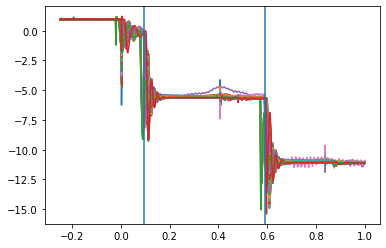

In [9]:
df_data_cut.plot(legend=False) 
ee_odd = float(mp3_fpa_df_subset['Delta_t(EE_odd-PIC)'].values[0]) / 1000
ee_even = float(mp3_fpa_df_subset['Delta_t(EE_even-PIC)'].values[0]) / 1000

plt.axvline(x=ee_odd)
plt.axvline(x=ee_even)

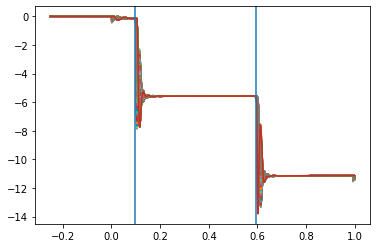

In [10]:
df_sim_noq_resampled.plot(legend=False) 
ee_odd = float(mp3_fpa_df_subset['Delta_t(EE_odd-PIC)'].values[0]) / 1000
ee_even = float(mp3_fpa_df_subset['Delta_t(EE_even-PIC)'].values[0]) / 1000

plt.axvline(x=ee_odd)
plt.axvline(x=ee_even)

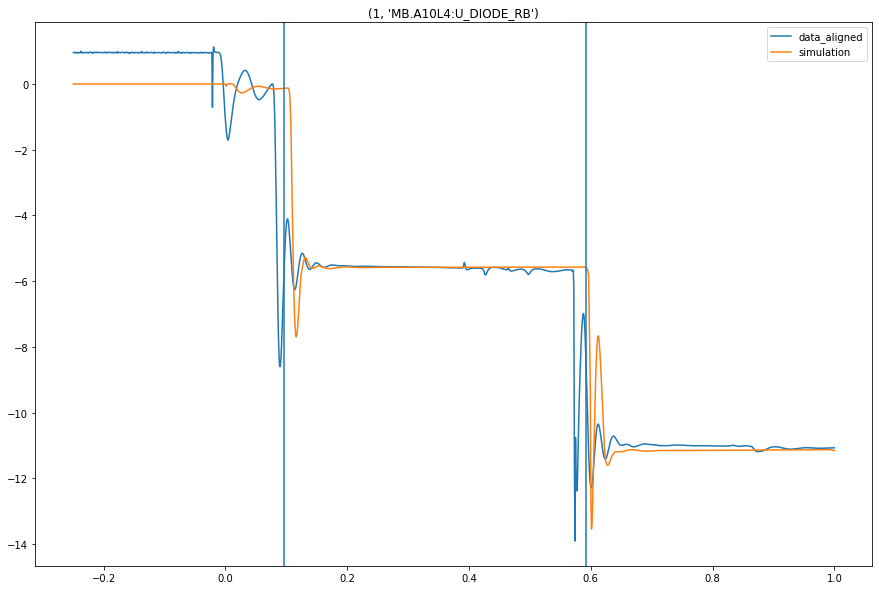

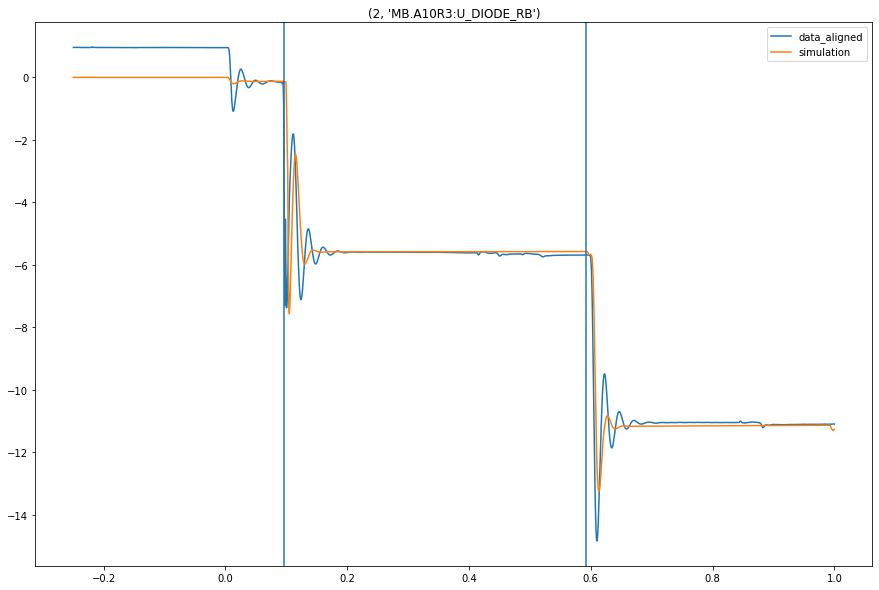

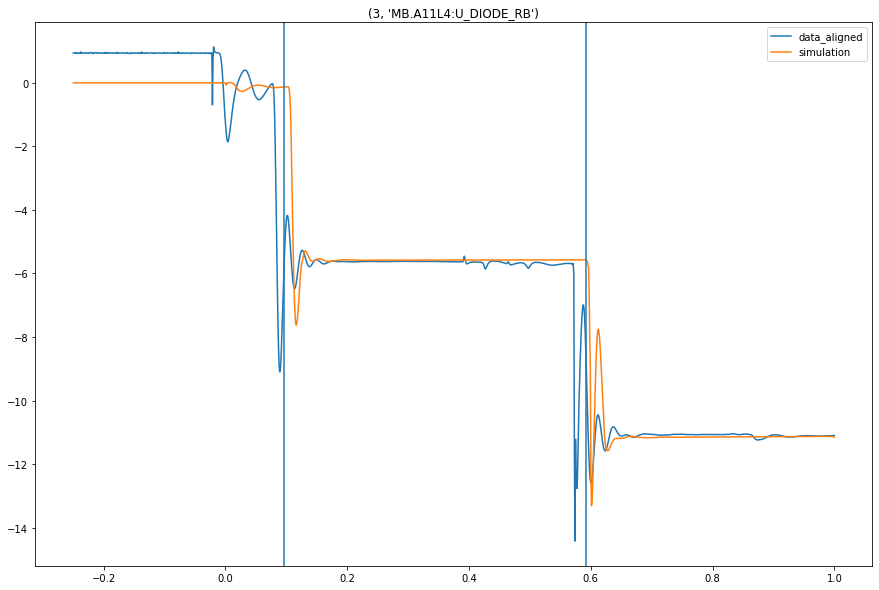

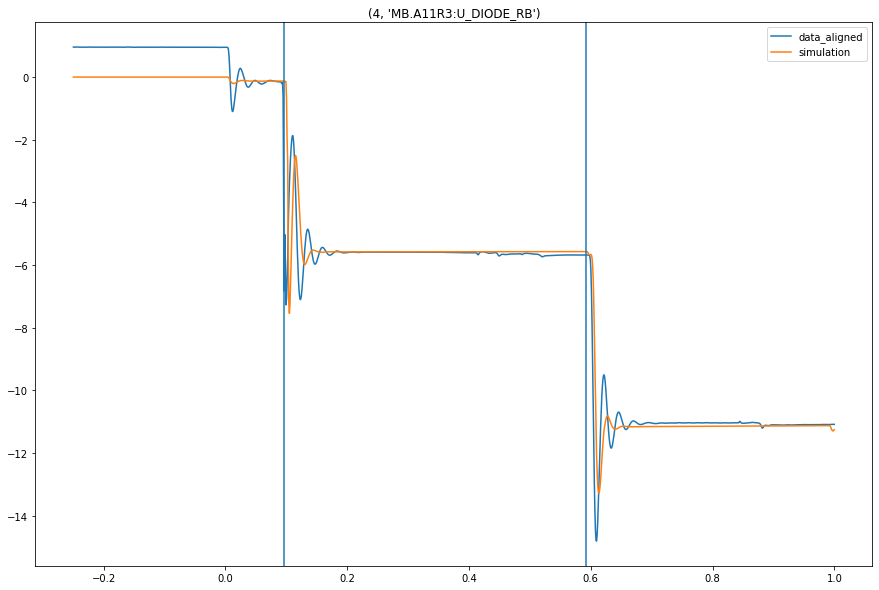

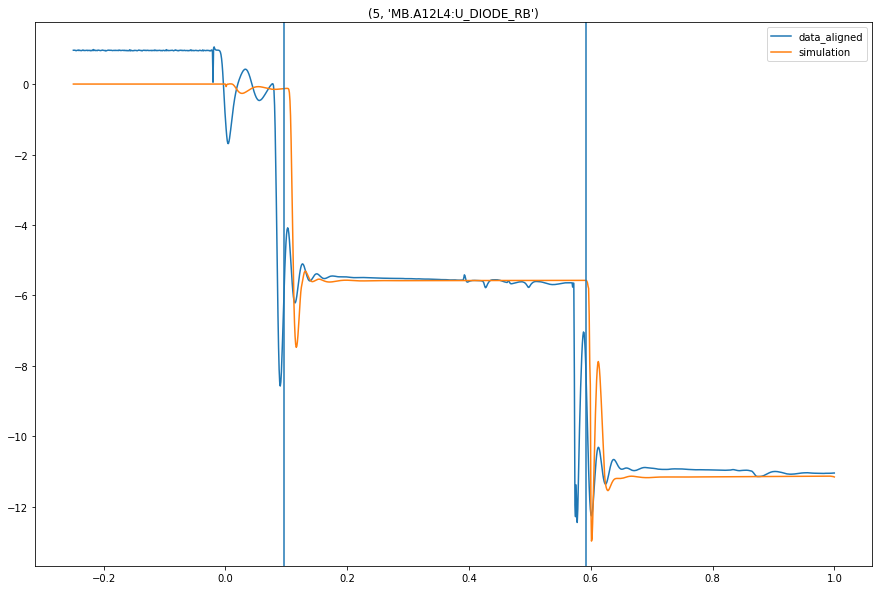

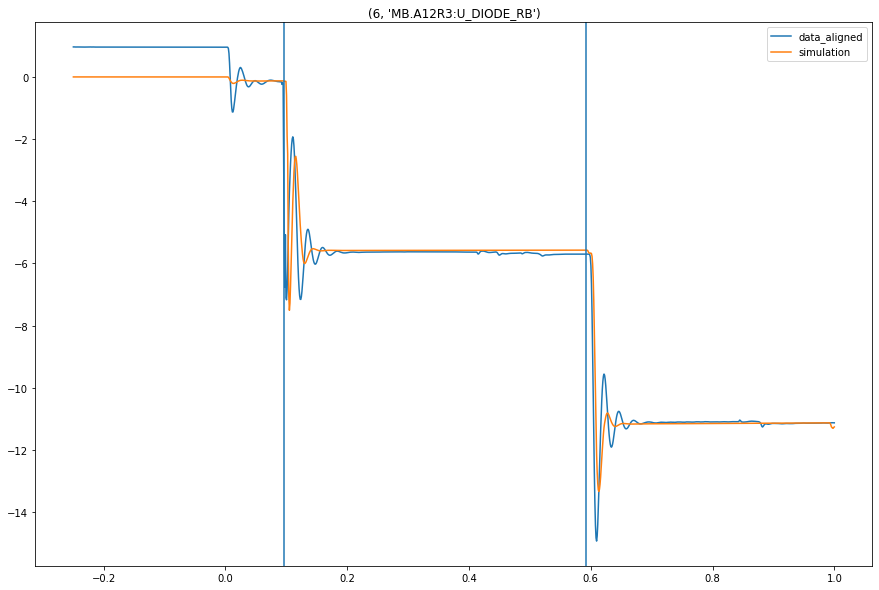

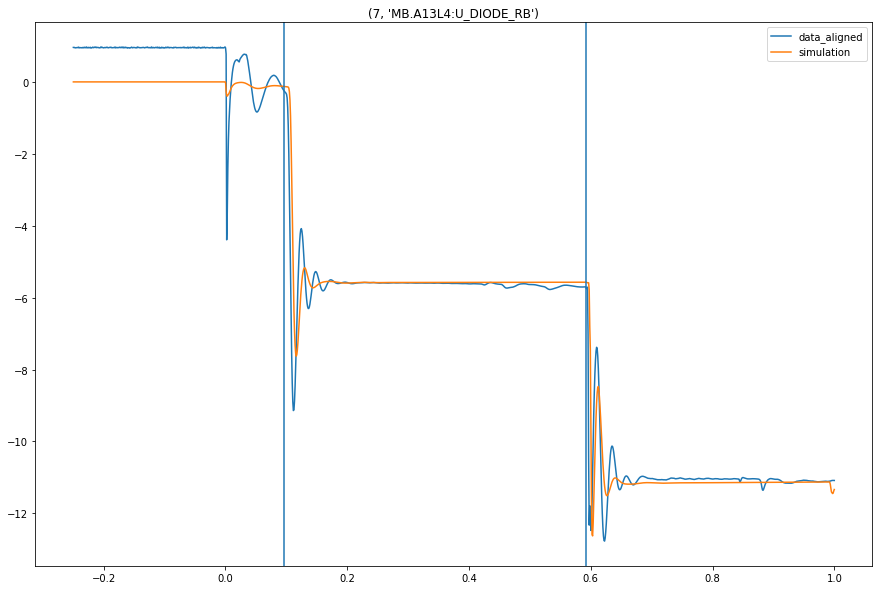

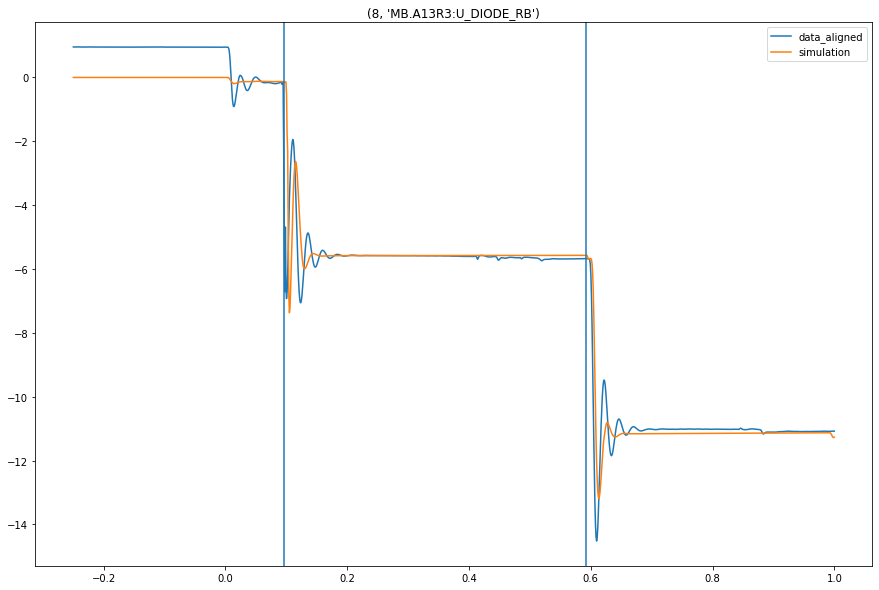

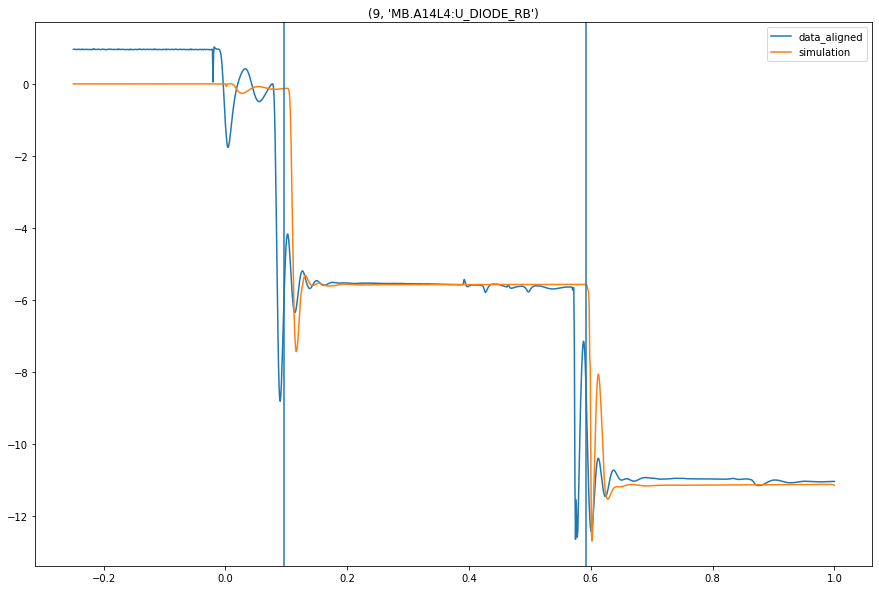

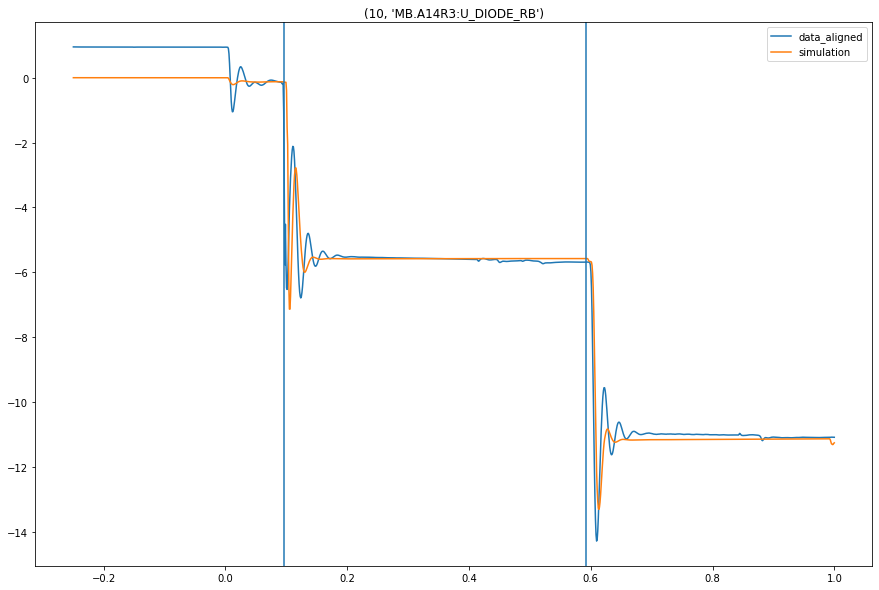

In [11]:
i =1
for c in df_data_aligned.columns:
    fig, ax = plt.subplots(figsize = (15,10))
    df_data_cut[c].plot(ax=ax, label="data_aligned")
    #df_data_noq[c].plot(ax=ax, label="data")
    #df_data_aligned
    df_sim_noq_resampled[c].plot(ax=ax, label="simulation")
    plt.title(f"{i,c}")
    plt.legend()
    
    ee_odd = float(mp3_fpa_df_subset['Delta_t(EE_odd-PIC)'].values[0]) / 1000
    ee_even = float(mp3_fpa_df_subset['Delta_t(EE_even-PIC)'].values[0]) / 1000
    plt.axvline(x=ee_odd)
    plt.axvline(x=ee_even)

    i+=1
    if i > 10:
        break

# Align all events

In [ ]:
faulty_sim_events = ["RB_RB.A45_1619677558420000000","RB_RB.A34_1619762968760000000"]

In [ ]:
i =1
dataset = []
for k, row in df_to_analyze.iterrows():
    circuit_name = row['Circuit Name']
    timestamp_fgc = int(row['timestamp_fgc'])
    fpa_identifier = f"{row['Circuit Family']}_{row['Circuit Name']}_{int(row['timestamp_fgc'])}"
    
    mp3_fpa_df_subset = mp3_fpa_df[(mp3_fpa_df.timestamp_fgc == row['timestamp_fgc']) & 
                                   (mp3_fpa_df['Circuit Name'] == row['Circuit Name'])]
    all_quenched_magnets = mp3_fpa_df_subset.Position.values
    quench_times = mp3_fpa_df_subset["Delta_t(iQPS-PIC)"].values /1e3
    
    # load simulation 
    simulation_dir = simulation_path / (fpa_identifier + ".hdf")
    plot_dir = data_path.parent / f"20220707_udiode_aligned_plots_nosim/{fpa_identifier}.png"
    
    if os.path.isfile(simulation_dir) and not os.path.isfile(plot_dir):# and not (fpa_identifier in faulty_events):
        data_sim = load_from_hdf_with_regex(file_path=simulation_dir, regex_list=["0v_magf"])
        df_sim = u_diode_simulation_to_df(data_sim, circuit_name=circuit_name)

            # load data
        data_dir = data_path / (fpa_identifier + ".hdf5")
        data = load_from_hdf_with_regex(file_path=data_dir, regex_list=['VoltageNQPS.*U_DIODE'])
        df_data = u_diode_data_to_df(data, len_data=len(data[0]))

        # load simulation 
        simulation_dir = simulation_path / (fpa_identifier + ".hdf")
        data_sim = load_from_hdf_with_regex(file_path=simulation_dir, regex_list=["0v_magf"])
        df_sim = u_diode_simulation_to_df(data_sim, circuit_name=circuit_name)

        # save magnet order for later useage
        magnet_list=df_sim.columns

        # drop quenched magnet
        max_time = df_data.index.max()
        df_data_noq = drop_quenched_magnets(df_data, all_quenched_magnets, quench_times, max_time)
        df_sim_noq = drop_quenched_magnets(df_sim, all_quenched_magnets, quench_times, max_time)

        # sometimes only noise is stored, mean must be in windwo -1, -10
        df_data_noq = df_data_noq.drop(df_data_noq.columns[~(-1>df_data_noq.mean()) & (-10<df_data_noq.mean())], axis=1)

        # align 
        t_first_extraction = min(float(mp3_fpa_df_subset['Delta_t(EE_odd-PIC)'].values[0]) / 1000, 
                                 float(mp3_fpa_df_subset['Delta_t(EE_even-PIC)'].values[0]) / 1000)
        df_data_aligned = align_u_diode_data(df_data_noq.copy(), t_first_extraction)

        # cut out time frame to analyze, [-0.25, 1] is 1336 samples
        time_frame = [-0.25, 1]
        df_data_cut = df_data_aligned[(time_frame[0] <= df_data_aligned.index) & (time_frame[1] >= df_data_aligned.index)]

        # adjust simulation length to data 
        df_sim_noq_resampled = interp(df_sim_noq, df_data_cut.index)

        # add quenched magnets again for continuity
        dropped_columns_data = magnet_list[~magnet_list.isin(df_data_cut.columns)]
        dropped_columns_simulation = magnet_list[~magnet_list.isin(df_sim_noq_resampled.columns)]
        df_data_cut[dropped_columns_data] = np.nan
        df_sim_noq_resampled[dropped_columns_simulation] = np.nan
        # bring into electrical order again
        df_data_cut = df_data_cut[magnet_list]
        df_sim_noq_resampled = df_sim_noq_resampled[magnet_list]

        # add data and simulation
        xr_array = data_to_xarray(df_data=df_data_cut, df_simulation=df_sim_noq_resampled, event_identifier=fpa_identifier)
        dataset.append(xr_array)

        fig, ax = plt.subplots(2,1, figsize = (15,10))
        df_data_cut.plot(legend=False, ax=ax[0])
        ax[0].set_title("data")
        ax[0].axvline(x=t_first_extraction)

        df_sim_noq_resampled.plot(legend=False, ax=ax[1])
        ax[1].set_title("simulation")
        plt.setp(ax, ylim=ax[0].get_ylim(), xlim=ax[0].get_xlim())
        plt.tight_layout()

        print(len(df_sim_noq_resampled))

        plt.savefig(plot_dir)
        plt.close(fig)

xr.concat(dataset, dim="event")